In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import plotly.express as px

In [2]:
os.listdir()

['.ipynb_checkpoints',
 '.virtual_documents',
 'history.csv',
 'ookla-speedtest-1.0.0-win64',
 'speedtest.exe',
 'speedtest.ipynb',
 'test.csv']

In [3]:
# directory = os.listdir()[1]
filename = "speedtest.exe"
output_file = "test.csv"
options = f"--output-header -f csv > {output_file}"

try:
    history_df = pd.read_csv('history.csv')
except:
    history_df = pd.DataFrame()

history_df.head(10)


,server name,server id,latency,jitter,packet loss,download,upload,download bytes,upload bytes,share url,date
0,"Whitesky Communications LLC - Denver, CO",23628,11.025,3.126,0.0,30355763,4837698,281271815,21443895,https://www.speedtest.net/result/c/a6a95362-df...,2021-10-18 21:29:15.575028
1,"Netprotect - Denver, CO",37501,13.809,1.557,NaN,31060261,5003153,435068276,57800253,https://www.speedtest.net/result/c/19a583e5-60...,2021-10-19 17:43:58.106283
2,"FORETHOUGHT.net - Denver, CO",3964,11.559,0.332,NaN,32746075,5198416,309383834,75085756,https://www.speedtest.net/result/c/27be1ae4-94...,2021-10-21 00:20:48.221446
3,"Verso Networks - Denver, CO",20818,10.587,4.622,0.0,31908088,5235317,391090968,63837666,https://www.speedtest.net/result/c/ba68f556-90...,2021-10-21 16:54:34.641856
4,"ALLO - Denver - Denver, CO",24079,11.315,2.363,0.0,1305630,1055633,17899072,14158249,https://www.speedtest.net/result/c/0e7cf808-5a...,2021-11-05 10:04:58.192000
5,"Aerux Broadband - Denver, CO",14861,10.750,0.836,NaN,10331287,1251992,98128060,16914863,https://www.speedtest.net/result/c/488561fd-91...,2021-11-05 10:08:25.422937
6,"CenturyLink - Denver, CO",8862,11.949,1.379,0.0,1147675,1653190,15821272,22402790,https://www.speedtest.net/result/c/b7398997-8a...,2021-11-05 10:11:57.313476
7,"Aerux Broadband - Denver, CO",14861,12.469,1.098,NaN,28749542,5181912,332993874,75034881,https://www.speedtest.net/result/c/b90bd893-f0...,2021-11-05 10:42:42.830864


In [7]:
os.system(f"{filename} {options}")


0

In [8]:
data_df = pd.read_csv(output_file)
data_df['date'] = [dt.datetime.now()]
data_df.head()

,server name,server id,latency,jitter,packet loss,download,upload,download bytes,upload bytes,share url,date
0,"Netprotect - Denver, CO",37501,10.309,0.5,NaN,35810888,5197627,471812096,27377889,https://www.speedtest.net/result/c/d6448047-15...,2021-12-03 09:46:24.333855


Chop the entire history file down to the columns we care about and then scale them by 8 to convert from Bps to bps

In [10]:
history_df = history_df.append(data_df)

In [11]:
plot_df = history_df.copy()
plot_df = plot_df[['date', 'download', 'upload']]
plot_df.loc[:, 'download'] *= 8 / 1e6
plot_df.loc[:, 'upload'] *= 8 / 1e6
print(plot_df.tail(5))

                         date    download     upload
6  2021-11-05 10:11:57.313476    9.181400  13.225520
7  2021-11-05 10:42:42.830864  229.996336  41.455296
0  2021-12-03 09:35:10.419787    7.540176  15.619992
0  2021-12-03 09:46:24.333855  286.487104  41.581016
0  2021-12-03 09:46:24.333855  286.487104  41.581016


In [6]:
ymd = [x.strftime('Y-m-d') for x in plot_df['date']]
plot_df['YMD'] = ymd


AttributeError: 'str' object has no attribute 'strftime'

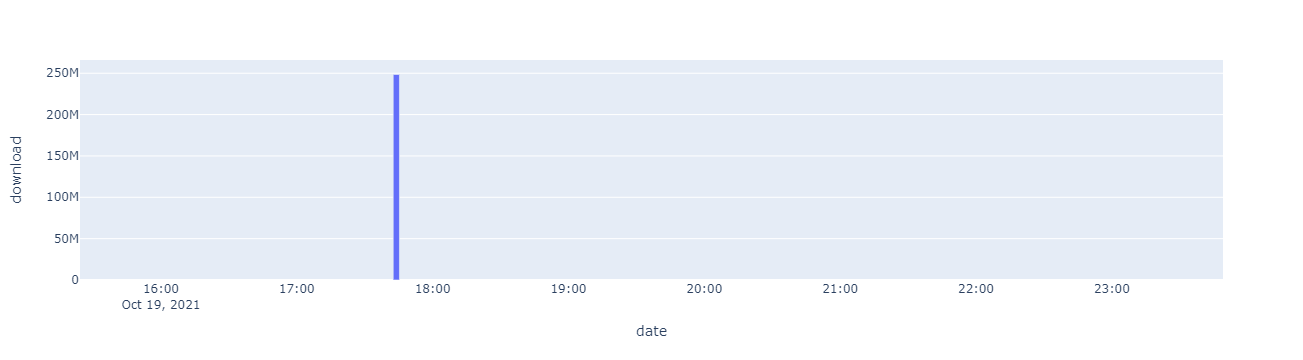

In [18]:
fig = px.bar(plot_df, x='date', y='download')
# fig.update_traces(width=10000)
fig.show()

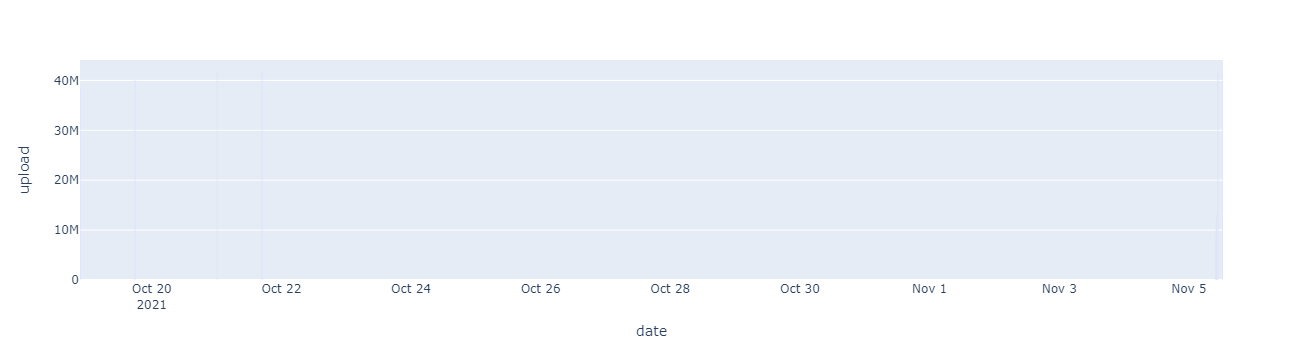

In [8]:
fig = px.bar(plot_df, x='date', y='upload')
fig.show()

In [25]:
plot_df.head(10)

,date,download,upload
0,2021-10-18 21:29:15.575028,242846104,38701584
1,2021-10-19 17:43:58.106283,248482088,40025224
2,2021-10-21 00:20:48.221446,261968600,41587328
3,2021-10-21 16:54:34.641856,255264704,41882536
4,2021-11-05 10:04:58.192000,10445040,8445064
5,2021-11-05 10:08:25.422937,82650296,10015936
6,2021-11-05 10:11:57.313476,9181400,13225520
0,2021-11-05 10:42:42.830864,229996336,41455296


In [26]:
history_df.to_csv('history.csv', index=False)